In [363]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import os
import sys

# use_gpu = torch.cuda.is_available()

In [364]:
#DATA LOADING
x = np.load('data/data_lstm/X_norm.npy')
y = np.load('data/data_lstm/Y_norm.npy')
print("x shape: ",x.shape)
print("y shape: ", y.shape)

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x,y,shuffle=True,test_size=0.2)

print("x_train: ",x_train.shape)
print("y_train: ",y_train.shape)

print("x_test: ",x_test.shape)
print("y_test: ",y_test.shape)

x shape:  (410, 600, 10)
y shape:  (410,)
x_train:  (328, 600, 10)
y_train:  (328,)
x_test:  (82, 600, 10)
y_test:  (82,)


In [365]:
#tensors

seq_len = 50

# sequences = torch.FloatTensor([dataset[(seq_len*t):(seq_len*t)+seq_len] for t in range(len(dataset)-seq_len)])
pilots = torch.FloatTensor([x_train[t] for t in range(328)])
print('sequences shape: ', pilots.shape)
# sequences = sequences.cuda()

# targets = torch.FloatTensor([targets[t+seq_len-1] for t in range(len(targets)-seq_len)])
targets = torch.FloatTensor([y_train[t] for t in range(328)])
print(targets.shape)
targets = targets.view(-1,1)
print(targets.shape)
# targets = targets.cuda()

print('pilots size.(0): ', pilots.size(0))
print('pilots shape: ', pilots.shape)

test_pilots = torch.FloatTensor([x_test[t] for t in range(82)])
test_targets = torch.FloatTensor([y_test[t] for t in range(82)])
print("test pilots shape:", test_pilots.shape)
print("test target shape:", test_targets.shape)


sequences shape:  torch.Size([328, 600, 10])
torch.Size([328])
torch.Size([328, 1])
pilots size.(0):  328
pilots shape:  torch.Size([328, 600, 10])
test pilots shape: torch.Size([82, 600, 10])
test target shape: torch.Size([82])


In [366]:
def pytorch_rolling_window(x, window_size, step_size):
    # unfold dimension to make our rolling window
    return x.unfold(0,window_size,step_size)

# make a range sequence sample
x = pilots[0]

# ie. window size of 5, step size of 1

print(pytorch_rolling_window(x,50,50).shape)


torch.Size([12, 10, 50])


In [367]:
#Define the model
class LSTM_model(nn.Module):
    def __init__(self):
        super(LSTM_model, self).__init__()
        
        self.input_size = 10
        self.hidden_size = 38
        self.num_layers = 1
        self.dropout = 0.1
        self.bias = False
        self.batch_first = False
        self.bidirectional = False

#         self.input_size2 = self.hidden_size
#         self.hidden_size2 = 60
#         self.num_layers2 = 1
#         self.dropout2 = 0.1
#         self.bias2 = False
#         self.batch_first2 = False
#         self.bidirectional2 = False
        
        
        self.lstm = nn.LSTM(self.input_size,
                            self.hidden_size,
                            self.num_layers, 
                            self.bias,
                            self.batch_first,
                            self.dropout,
                            self.bidirectional)
#         self.lstm2 = nn.LSTM(self.input_size2,
#                             self.hidden_size2,
#                             self.num_layers2, 
#                             self.bias2,
#                             self.batch_first2,
#                             self.dropout2,
#                             self.bidirectional2)

        self.linear = nn.Linear(self.hidden_size*50*12, 1)

        
    def forward(self, input1, hidden):

        out, (h_t, c_t) = self.lstm(input1, hidden)
#         out = out[-1][:,None, :]
#         out, (h_t2, c_t2) = self.lstm2(out, hidden2)
        out = out.reshape(1, self.hidden_size*50*12)
#         print(out.shape)
        
        out = self.linear(out)
#         out = np.array(out)
#         print("out.shape: " ,out.shape)
        
#         if (out>0.5):
#             out[0] = int(1)
#         else:
#             out[0] = int(0)
        
#         print(out)
                
        return out
              
    def init_hidden(self, batch_size):
        hidden = (torch.zeros(self.num_layers, batch_size, self.hidden_size),
                 (torch.zeros(self.num_layers, batch_size, self.hidden_size)))
        return hidden
    
#     def init_hidden2(self, batch_size):
#         hidden2  = (torch.zeros(self.num_layers2, batch_size, self.hidden_size2),
#                  (torch.zeros(self.num_layers2, batch_size, self.hidden_size2)))
#         return hidden2


In [368]:
model = LSTM_model()
learning_rate = 0.0009
max_grad_norm = 4
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

batch_size = 12
num_epochs = 1
num_batches = 1

loss_values = []

#for every pilot, I train 5 epochs of 1 batch
for a_pilot in range(328):
    
    #600 datapoints per pilot
    x_data = pilots[a_pilot]
    
    y_targets = targets[a_pilot]
#     print(type(y_targets[0]))
#     y_targets =y_targets.type(torch.LongTensor)
#     print("x_data.shape:",x_data.shape)
#     print("y_targets.shape:", y_targets.shape)
    
    sequences = pytorch_rolling_window(x_data,50,50)
#     print(sequences.shape)
    
    sequences = np.transpose(sequences,(2,0,1))
#     print(sequences.shape)
    
    num_sequences = 12
    num_batches = num_sequences // batch_size
    
#     print("Pilot {} : Training model for {} epoch of {} batches".format(a_pilot,num_epochs, num_batches))
    if (y_targets[0] == 1):
        num_epochs = 2
    else:
        num_epochs = 1
    for epoch in range(num_epochs):
        total_loss = 0
        
        #reset the gradient
        model.zero_grad()

        #initialize the hidden state
        hidden = model.init_hidden(batch_size)

        #complete a forward pass
        y_pred = model(sequences, hidden)
        y_pred = torch.reshape(y_pred, (-1,))
#         print(y_pred.shape)

        #calculate the loss with the loss_fn
        loss = loss_fn(y_pred, y_targets)
#         loss_values.append(loss)
        
#       print(y_pred.shape, y_targets.shape, sequences.shape)

        #compute the gradient
        loss.backward()

        #clip to the gradient to avoid exploding gradient
        nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

        #make on step with optimizer
        optimizer.step()

        #accumulate the total loss
        total_loss += loss.data

        print("Epoch {}: Loss = {:.8f}".format(epoch+1, total_loss/num_batches))
        loss_values.append(total_loss/num_batches)
    

Epoch 1: Loss = 0.00002330
Epoch 1: Loss = 1.35496652
Epoch 1: Loss = 1.56670165
Epoch 2: Loss = 0.05171247
Epoch 1: Loss = 0.67610019
Epoch 2: Loss = 1.26208162
Epoch 1: Loss = 4.13621092
Epoch 1: Loss = 1.62832510
Epoch 1: Loss = 0.81724709
Epoch 2: Loss = 0.17600675
Epoch 1: Loss = 0.00535805
Epoch 2: Loss = 0.16398881
Epoch 1: Loss = 0.55886906
Epoch 2: Loss = 0.61977744
Epoch 1: Loss = 0.38200745
Epoch 1: Loss = 0.11890870
Epoch 2: Loss = 0.00464373
Epoch 1: Loss = 0.49090981
Epoch 1: Loss = 3.63188457
Epoch 2: Loss = 2.83670878
Epoch 1: Loss = 0.05586225
Epoch 2: Loss = 0.10741551
Epoch 1: Loss = 0.22680514
Epoch 2: Loss = 0.08981839
Epoch 1: Loss = 1.61650038
Epoch 1: Loss = 1.54486060
Epoch 2: Loss = 1.29605246
Epoch 1: Loss = 0.07975554
Epoch 1: Loss = 0.15537642
Epoch 2: Loss = 0.02197120
Epoch 1: Loss = 0.48111063
Epoch 1: Loss = 0.18646079
Epoch 1: Loss = 3.74156237
Epoch 2: Loss = 4.61603165
Epoch 1: Loss = 0.52916503
Epoch 1: Loss = 1.66756940
Epoch 2: Loss = 1.57084620
E

Epoch 2: Loss = 0.03390963
Epoch 1: Loss = 0.50115591
Epoch 1: Loss = 0.42411864
Epoch 1: Loss = 1.11627400
Epoch 2: Loss = 0.97250223
Epoch 1: Loss = 1.47855556
Epoch 1: Loss = 0.20989610
Epoch 2: Loss = 0.15100810
Epoch 1: Loss = 0.38508153
Epoch 1: Loss = 1.84969115
Epoch 1: Loss = 0.64648372
Epoch 1: Loss = 0.00055638
Epoch 2: Loss = 0.00199631
Epoch 1: Loss = 0.01357695
Epoch 2: Loss = 0.00482973
Epoch 1: Loss = 0.00057985
Epoch 2: Loss = 0.00044221
Epoch 1: Loss = 0.08943499
Epoch 2: Loss = 0.09014809
Epoch 1: Loss = 0.19809943
Epoch 2: Loss = 0.14552656
Epoch 1: Loss = 0.00127180
Epoch 2: Loss = 0.01050805
Epoch 1: Loss = 0.44082355
Epoch 1: Loss = 0.00928240
Epoch 2: Loss = 0.00916151
Epoch 1: Loss = 0.24182674
Epoch 1: Loss = 1.06374609
Epoch 1: Loss = 0.00150674
Epoch 1: Loss = 0.01530674
Epoch 1: Loss = 0.09490261
Epoch 2: Loss = 0.06310124
Epoch 1: Loss = 0.79739600
Epoch 1: Loss = 0.63270313
Epoch 1: Loss = 0.55888253
Epoch 1: Loss = 0.21517310
Epoch 2: Loss = 0.27760318
E

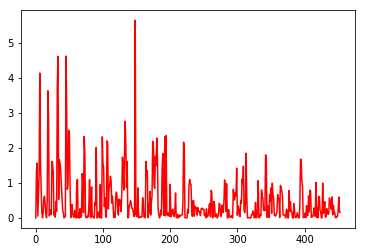

In [369]:
#TESTING
plt.plot(np.array(loss_values), 'r')
plt.show()


82


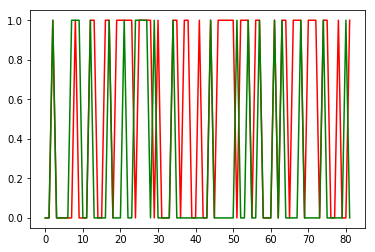

accurate:  47
not accurate:  35
accuracy: {:.8f}% 57.3170731707317
bad:  6
0.573170731707317


In [370]:
#TESTING ACCURACY
hidden = model.init_hidden(12)
pred = []
for a_pilot in range(82):
    
    pilot = test_pilots[a_pilot]
    
    sequences = pytorch_rolling_window(pilot,50,50)
    sequences = np.transpose(sequences,(2,0,1))
    
    a_pred = model(sequences, hidden)
    
    pred.append(int(a_pred+0.5))
    
print(len(pred))
# print(pred)

plt.plot(np.array(pred), 'r')
plt.plot(y_test, 'g')
plt.show()

accurate = 0
n_acc = 0
bad = 0
for i in range(82):
    if y_test[i] == pred[i]:
        accurate += 1
    else:
        n_acc += 1 
        if y_test[i] == 1:
            bad += 1
        
print("accurate: ", accurate)
print("not accurate: ", n_acc)
accuracy = accurate/(n_acc + accurate)
print("accuracy: {:.8f}%", 100*accuracy)
print("bad: ", bad)

from sklearn.metrics import f1_score
f = f1_score(y_test, pred, average = 'micro')
print(f)

